In [628]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.misc import derivative
import matplotlib.pyplot as plt

### Simulating waveform as per frequency model

In [629]:
pi = np.pi
M = 30*1.99*10**30 # Chirp mass
G = 6.67*10**(-11)
c = 299792458
D=10^11
h0=1
phi0 = 0
tc0 = -4/2944 # Because at t=0 we get singularities

In [630]:
def frequency(t): # Valid for t<0
    return np.power( abs(np.power(8*pi,8/3)/5*np.power(G*M/c**3, 5/3)*(-t)) , -3/8)

In [631]:
# Diverged from actual derivative close to 0, so replaced with the function in the next cell
def derivativeFrequency2(t):
    return derivative(frequency, t, dx=0.001)

In [632]:
def derivativeFrequency(t): # Valid for t<0
    return 3/8*np.power( np.power(8*pi,8/3)/5*np.power(G*M/c**3, 5/3) , -3/8)*np.power(abs(-t),-11/8)

In [633]:
def phase(t):
    return 2*pi*frequency(t)*t + pi*derivativeFrequency(t)*t**2 + phi0

In [634]:
def sineAmplitude(t):
    return h0*4*G*M/c**2/D*np.power(G*pi*M/c**3*frequency(t), 2/3)

In [635]:
def sineWave(t): 
    return np.cos(phase(t))

In [673]:
def sineGaussianWave(t):
    return np.exp(-20000*t**2)*np.cos((2*pi*frequency(tc0))*t)

In [674]:
def waveform2(t):
    if t <= tc0:
        return sineAmplitude(t)*sineWave(t)
    else:
        return 0

In [675]:
def waveform(t):
    if t <= tc0:
        return sineAmplitude(t)*sineWave(t)
    else:
        return sineAmplitude(tc0)*sineWave(tc0)*sineGaussianWave(t-tc0)

In [676]:
def plotTimeInterval(x,T):
    plt.plot(np.linspace(0,T,len(x)), x)

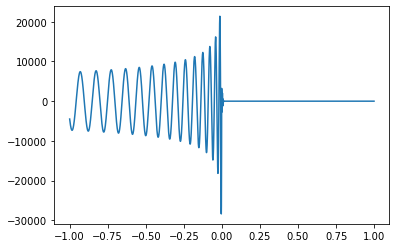

In [677]:
timeSeriesTest = np.arange(-1,1,2/2944)
simWaveTest = np.array([waveform(t) for t in timeSeriesTest])
plt.plot(timeSeriesTest,simWaveTest)

### Working with measured data

In [641]:
with open("GW150914 (filtered data).txt", "r") as f:
    data = f.read()
measWave = np.array([float(x) for x in data.rstrip().split("\n")])

In [642]:
measWave

array([2.17393078e-22, 2.03306760e-22, 1.94185335e-22, ...,
       1.74406401e-22, 2.09175993e-22, 2.40556341e-22])

In [643]:
nPerSec = int(len(measWave)/64) # 64 second long measurement, so 2944 datapoints per second
nPerSec

2944

In [644]:
tcGuess = 94208+1177+500+20+5 # This is the exact datapoint at which coalescence seems to happen
tcGuess

95910

In [645]:
pointSeries=np.arange(64*nPerSec)
timeSeries = pointSeries/nPerSec
timeSeries

array([0.00000000e+00, 3.39673913e-04, 6.79347826e-04, ...,
       6.39989810e+01, 6.39993207e+01, 6.39996603e+01])

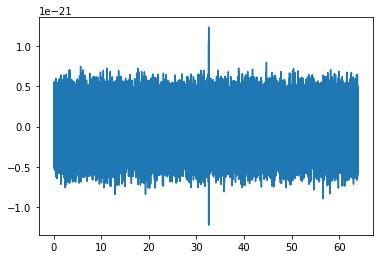

In [656]:
plt.plot(timeSeries, measWave)

In [646]:
def corrWithMeasWave(simulatedWave):
    return pd.Series(measWave).corr(pd.Series(simulatedWave))

In [647]:
def correlation(tc):
    simWave = np.array([waveform(t-tc) for t in timeSeries])
    return corrWithMeasWave(simWave)

In [678]:
# timeSeries2 = np.linspace(0,63,64)
timeSeries2 = np.arange(0,64,(1/32))
corrLength = len(timeSeries2)
pointsStep = int(64*nPerSec/corrLength)
correlationPlot = np.empty(corrLength)
correlationPlot2 = np.empty(corrLength)
# print(timeSeries2, corrLength, pointsStep)

In [695]:
# %%timeit
for n in range(corrLength):
    if n==0:
#         simWave = np.array([waveform(t) for t in timeSeries])
#         simWave2 = np.full(len(timeSeries),0)
        splitPoint = 8*nPerSec
        simWave = np.array([waveform(t) for t in timeSeries[0:splitPoint]]+
                           [waveform(t-64) for t in timeSeries[splitPoint:64*nPerSec]])
        simWave2 = np.array([waveform2(t-64) for t in timeSeries])
        correlationPlot[n] = corrWithMeasWave(simWave)
        correlationPlot2[n] = corrWithMeasWave(simWave2)
    else:
        insertInSimWave = []
        for i in range(pointsStep):
            insertInSimWave.append(waveform(timeSeries[i] - timeSeries2[n]))
        
        simWave = np.delete(np.insert(simWave,np.full(pointsStep,0),
                                      insertInSimWave),
                            np.arange(-pointsStep,0))
        correlationPlot[n] = corrWithMeasWave(simWave)
        
        insertInSimWave2 = []
        for i in range(pointsStep):
            insertInSimWave2.append(waveform2(timeSeries[i] - timeSeries2[n]))
        
        simWave2 = np.delete(np.insert(simWave2,np.full(pointsStep,0),
                                      insertInSimWave2),
                            np.arange(-pointsStep,0))
        correlationPlot2[n] = corrWithMeasWave(simWave2)

Text(0.5, 1.0, 'With Gaussian')

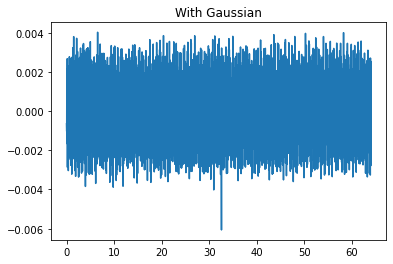

In [696]:
plt.plot(timeSeries2, correlationPlot)
plt.title("With Gaussian")

Text(0.5, 1.0, 'Without Gaussian')

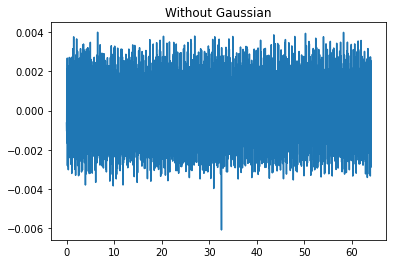

In [697]:
plt.plot(timeSeries2, correlationPlot2)
plt.title("Without Gaussian")

In [699]:
count = 0
for i in range(len(timeSeries2)):
    if abs(correlationPlot[i]-correlationPlot2[i])<0.0001: count+=1
count/len(timeSeries2)

0.99755859375

In [653]:
(frequency(-4/2944))

214.25417190441732